<font color='blue'> **Pathlines_mf6_mp7** </font>    w04b

In [1]:
import os; import sys; from pathlib import Path; from pprint import pformat ; from shutil import copytree ; import matplotlib as mpl ; 
import matplotlib.pyplot as plt ; import numpy as np ; import pandas as pd; import shapefile ; import flopy ; from os.path import join; import csv 
import numpy.ma as ma

In [2]:
sim_ws = Path('E:\\15_REPOS\\00_BETAMI\\94_floPy\\04_w04c')       ; sim_ws.mkdir(exist_ok=True)  
sim_name = model_name   = "track_whirl" ; exe_name = "mf6"           ; output_folder = ws = workspace = sim_ws  

In [3]:
nper, nstp, perlen, tsmult = 1, 1, 1.0, 1.0    ; nlay, nrow, ncol = 10, 12, 51     ; delr = 100 ;  delc = 100
top = 0 ; botm_str = "-100, -200, -300, -400, -500, -600, -700, -800, -900, -1000" ; botm=[float(value)for value in botm_str.split(",")] 
k11= [1,1,1,1,1,1,1,1,1,1]                                       
k33= [1,1,1,1,1,1,1,1,1,1]                                                         ; k22 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]      
angle1_str = "45, 45, 45, 45, 45, -45, -45, -45, -45, -45"                         ; angle1=[float(value)for value in angle1_str.split(",")]
shape3d = (nlay, nrow, ncol)               ; pdd = (perlen, nstp, tsmult)          ; inflow_rate = 0.01 ; icelltype = [0,0,0,0,0,0,0,0,0,0]  
rate       = np.zeros((nlay, nrow, ncol), dtype=float)                             ; rate[:,:,0]=inflow_rate   ; rate[:,:,-1]=-inflow_rate
wZ, wR, wL = np.where(rate != 0.0)     ; wel_spd=[((k, i, j), rate[k, i, j]) for k,i,j in zip(wZ, wR, wL)]   ; wel_spd={0:wel_spd}

In [4]:
head_filerecord = f"{sim_name}.hds"  ; budget_filerecord = f"{sim_name}.cbc"
sim = flopy.mf6.MFSimulation   (sim_name=sim_name, exe_name="mf6", version="mf6", sim_ws=ws)
flopy.mf6.ModflowTdis(sim, time_units="days", nper=nper, perioddata=[pdd])
gwf = flopy.mf6.ModflowGwf    (sim, modelname = sim_name, save_flows=True)
flopy.mf6.ModflowIms     (sim ,linear_acceleration="bicgstab",outer_dvclose=1e-6 ,inner_dvclose=1e-6 ,rcloserecord=1e-6)
flopy.mf6.ModflowGwfdis  (gwf ,nlay=nlay ,nrow=nrow ,ncol=ncol ,length_units="meters" ,delr=delr ,delc=delc ,top=top ,botm=botm)
flopy.mf6.ModflowGwfic   (gwf ,strt=top)
flopy.mf6.ModflowGwfnpf  (gwf, icelltype=icelltype, k=k11, k22=k22, k33=k33 ,save_specific_discharge=True, xt3doptions=True , angle1=angle1) 
flopy.mf6.ModflowGwfwel  (gwf,stress_period_data=wel_spd,pname="WEL")
flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,
                          saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
sim.write_simulation(silent=True) ;sim.run_simulation(silent=True,report=False)

(True, [])

In [5]:
head = flopy.utils.HeadFile(workspace / f"{sim_name}.hds") ; heads = head.get_data()  ; ss =np.max(heads) - np.min(heads)
sim = flopy.mf6.MFSimulation.load(sim_ws = sim_ws ,exe_name = exe_name ,verbosity_level = 0) ; 
cobj = gwf.output.budget()                                                    ; spd = cobj.get_data(text="DATA-SPDIS")[0]      
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd, gwf)      ; levels=np.arange(np.min(heads[0]), np.max(heads[0]), ss/10) 

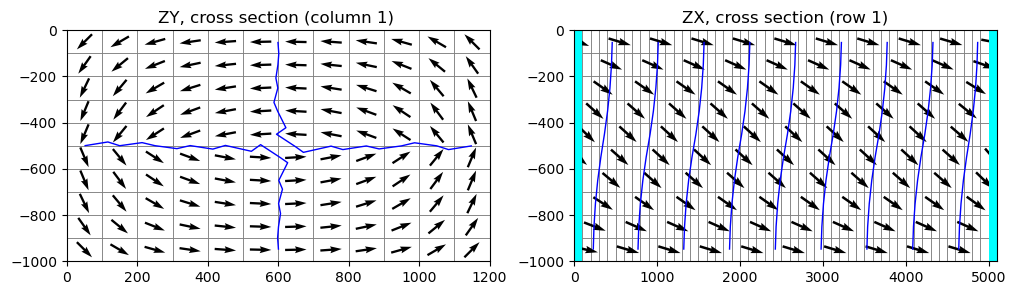

In [6]:
fig = plt.figure(figsize=(12, 3)) ; fig.tight_layout()  
ax = fig.add_subplot(121)    ; xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"column": 25}) ; ax.set_title("ZY, cross section (column 1) ") 
xs.plot_grid(lw=0.5)         ; xs.plot_vector(qx,qy,qz,normalize=True) 
xs.contour_array(heads,levels=levels,linewidths=1,colors="b",linestyles="solid") ; xs.plot_bc("Wel", color="cyan") 

ax = fig.add_subplot(122)    ; xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": 1})    ; ax.set_title("ZX, cross section (row 1)") 
xs.plot_grid(lw=0.5)         ; xs.plot_vector(qx,qy,qz,normalize=True, hstep=5)  ; xs.plot_bc("Wel", color="cyan") 
xs.contour_array(heads,levels=levels,linewidths=1,colors="b",linestyles="solid") ;  plt.show()

In [7]:
vvv   = [(0,0,2),(0,1,2),(0,2,2),(0,3,2),(0,17,2),(0,18,2),(0,19,2),(0,20,2)] ; 
part1 = flopy.modpath.ParticleData(vvv, drape=1, structured=True, particleids=[1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008])  
pg1 =flopy.modpath.ParticleGroup(particledata=part1,filename="Track_new") ; particlegroups=[pg1] ;np.savetxt(sim_ws/"02_path_IN.csv",vvv,delimiter=",")

In [ ]:
exe_name = "mp7"                #  ; zone3 = np.ones((nrow, ncol), dtype=np.int32)   ;  zone3[wel_loc[1:]] = 2  ; zones = [0, 0, zone3]
mp    = flopy.modpath.Modpath7    (modelname=sim_name + "_mp", flowmodel=gwf, exe_name=exe_name, model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas (mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim (mp, simulationtype="combined"  ,trackingdirection ="forward",weaksinkoption ="pass_through",
                                   weaksourceoption="pass_through",budgetoutputoption="summary",stoptimeoption ="extend",
                                   zonedataoption="on"    ,  particlegroups = particlegroups)   # zones  # particlegroups
mp.write_input() ; mp.run_model(silent=True, report=False)

In [ ]:
head = flopy.utils.HeadFile(workspace / f"{sim_name}.hds") ; heads = head.get_data()  ; ss =np.max(heads) - np.min(heads)
sim = flopy.mf6.MFSimulation.load(sim_ws = sim_ws ,exe_name = exe_name ,verbosity_level = 0) 
cobj = gwf.output.budget()  ; spd = cobj.get_data(text="DATA-SPDIS")[0] ; qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd, gwf)

In [ ]:
def get_nodes(locs):
    nodes = []
    for k, i, j in locs: nodes.append(k * nrow * ncol + i * ncol + j)
    return nodes
#nodew   = get_nodes([wel_loc]) ; 
cellids = gwf.wel.stress_period_data.get_data()[0]["cellid"]       ; nodesr  = get_nodes(cellids)
fpth = os.path.join(ws, model_name + "_mp.mppth")                  ; pp = flopy.utils.PathlineFile(fpth) ; 
#pw0 = pp.get_destination_pathline_data(nodew, to_recarray=True)    
pr1 = pp.get_destination_pathline_data(nodesr, to_recarray=True)

In [ ]:
fig = plt.figure(figsize=(15, 3))     ; ax = fig.add_subplot(111, aspect="equal")      ; ax.set_title("XY plan View (m)")       
mm = flopy.plot.PlotMapView(model=gwf, ax=ax)  ;ll=5  ; mm.plot_pathline(pr1,layer=ll,colors='green',lw=2)   
hdd=mm.plot_array(heads[ll],alpha=0.4) ; mm.plot_grid(linewidth=0.2) ; mm.plot_bc("WEL", plotAll=True,color="cyan") ; plt.show()

In [ ]:
# cellids

In [ ]:
#k11 = [1,1,1,1,1,1,1,1,1,1]                                       #k33 = [0.1,0.1,0.1,0.1,0.1,10,10,10,10,10]      
#k33 = [1,1,1,1,1,1,1,1,1,1]                                       #k22 = [10.0,10.0,10.0,10.0,10.0,0.10,0.10,0.10,0.10,0.10]
#k11 = [0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10]         #k11 = [1,1,1,1,1,1,1,1,1,1]    
#k33 = [0.1,0.1,0.1,0.1,0.1,10,10,10,10,10]                        #k22  = [0.01,0.01,0.01,0.01,0.01,10.0,10.0,10.0,10.0,10.0]
#k33  = [10.0,10.0,10.0,10.0,10.0,0.01,0.01,0.01,0.01,0.01]        #k33  = [0.01,0.01,0.01,0.01,0.01,10.0,10.0,10.0,10.0,10.0]
#angle1_str = "45, 45, 45, 45, 45, -45, -45, -45, -45, -45"        ; angle1=[float(value)for value in angle1_str.split(",")]